In [2]:
%matplotlib inline
from __future__ import print_function
import os
from pyspark import SQLContext
from pyspark.sql import Row
import pyspark.sql.functions as sql
import pyspark.sql.types as types
#from pyspark.sql.functions import udf, length
import matplotlib.pyplot as plt
import numpy
import math
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import pyspark.ml.feature as feature

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
# Load Processed Parquet
sqlContext = SQLContext(sc)
ols = sqlContext.read.json("../data/idigbio_envo_terms.json")
total_records = ols.count()
print(total_records)
ols.printSchema()


74130
root
 |-- noun: string (nullable = true)
 |-- response: struct (nullable = true)
 |    |-- description: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- id: string (nullable = true)
 |    |-- iri: string (nullable = true)
 |    |-- is_defining_ontology: boolean (nullable = true)
 |    |-- label: string (nullable = true)
 |    |-- obo_id: string (nullable = true)
 |    |-- ontology_name: string (nullable = true)
 |    |-- ontology_prefix: string (nullable = true)
 |    |-- short_form: string (nullable = true)
 |    |-- type: string (nullable = true)
 |-- term_id: string (nullable = true)
 |-- term_label: string (nullable = true)
 |-- time: string (nullable = true)



In [4]:
print(ols.filter(sql.col("term_id") != "").count())
print(ols.filter(sql.col("term_id") == "").count())

19131
54999


In [5]:
# Manually review a random sample of positive results and negative results
# Different random sample every time run
ols\
    .filter(sql.col("term_id") != "")\
    .sample(withReplacement=False, fraction=0.01)\
    .unionAll(
    ols\
        .filter(sql.col("term_id") == "")\
        .sample(withReplacement=False, fraction=0.002)
    )\
    .select(sql.col("noun"), sql.col("term_label"))\
    .show(1000, truncate=False)

+--------------------+------------------------------------------+
|noun                |term_label                                |
+--------------------+------------------------------------------+
|vegetative          |embryo                                    |
|iv-1-54             |cultivated environment                    |
|blue-green-gray     |blue cheese                               |
|butterflies         |wet meadow                                |
|lock                |lock                                      |
|posterior           |posterior lateral line ganglion           |
|shrubland           |shrubland biome                           |
|pg.                 |subiculum                                 |
|60-399              |ditch mouth                               |
|v:12b               |V-shaped                                  |
|boundary.           |boundary wall                             |
|gum                 |gingiva                                   |
|oak.     

In [13]:
# Need to filter out terms that were the result of mapping a numerical string
# criteria is perhaps more than one number in a string? (remember nouns had to
# be >2 chars to try to map)
def is_digit(s):
    return True in [c in s for c in "1234567890"]

is_digit_udf = sql.udf(is_digit, types.BooleanType())

ols_no_digits = ols\
    .where(is_digit_udf(sql.col("noun")) == False)
    
ols_no_digits.show(10)

+---------------+--------------------+--------------------+----------------+--------------------+
|           noun|            response|             term_id|      term_label|                time|
+---------------+--------------------+--------------------+----------------+--------------------+
|           fawn|[null,null,null,n...|                    |                |2016-04-16T22:55:...|
|      biennials|[null,null,null,n...|                    |                |2016-04-16T22:55:...|
|    vexillifera|[null,null,null,n...|                    |                |2016-04-16T22:55:...|
|          tasok|[null,null,null,n...|                    |                |2016-04-16T22:55:...|
|          peas.|[WrappedArray(A p...|envo:http://purl....|dry peas product|2016-04-16T22:55:...|
|cylindrosporium|[null,null,null,n...|                    |                |2016-04-16T22:55:...|
|      maderista|[null,null,null,n...|                    |                |2016-04-16T22:58:...|
|       dothidea|[nu

In [23]:
# What kinds of things were we finding?
terms = ols_no_digits\
    .dropna(subset=["term_id"])\
    .filter(sql.col("term_id") != "")\
    .groupBy(sql.col("term_id"), sql.col("term_label"))\
    .count()\
    .orderBy(sql.col("count"), ascending=False)
    
print(terms.count())
terms.show(20, truncate=False)
    


2385
+--------------------------------------------------+--------------------+-----+
|term_id                                           |term_label          |count|
+--------------------------------------------------+--------------------+-----+
|envo:                                             |Environment Ontology|67   |
|envo:http://purl.obolibrary.org/obo/ENVO_00000109 |woodland            |61   |
|envo:http://purl.obolibrary.org/obo/ENVO_00003887 |blue cheese         |50   |
|envo:http://purl.obolibrary.org/obo/ENVO_00003971 |brown sugar         |42   |
|envo:http://purl.obolibrary.org/obo/ENVO_00000337 |orange juice        |40   |
|envo:http://purl.obolibrary.org/obo/ENVO_00005790 |red soil            |39   |
|envo:http://purl.obolibrary.org/obo/ENVO_0010128  |cream               |39   |
|envo:http://purl.obolibrary.org/obo/ENVO_00000406 |mid-ocean ridge     |38   |
|envo:http://purl.obolibrary.org/obo/ENVO_01000257 |white smoker        |38   |
|envo:http://purl.obolibrary.org/ob

[]

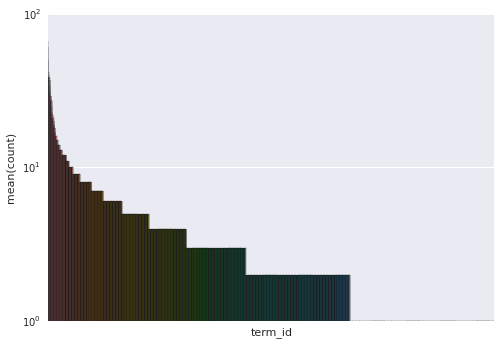

In [21]:
# Let's graph that distribution
terms_pdf = terms.toPandas()
import seaborn as sns
ax = sns.barplot(x="term_id", y="count", data=terms_pdf)
ax.set_yscale('log')
ax.get_xaxis().set_ticks([])